In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# GNOD Music recomender project

###  1. Scraping webs to check current top 100 songs

In [2]:
#fetching the webpage
url = 'http://www.popvortex.com/music/charts/top-100-songs.php'
response = requests.get(url)
html_content = response.content

In [3]:
#parsing
soup = BeautifulSoup(html_content, 'html.parser')

In [58]:
#print (soup.prettify())

In [5]:
#scraping artist and song elements
songs = soup.find_all('cite', class_='title')
artists = soup.find_all('em', class_='artist')

In [6]:
#extracting the text
song_titles = [song.get_text() for song in songs]
artist_names = [artist.get_text() for artist in artists]

In [7]:
#putting it into a dataframe
top100 = pd.DataFrame({
    'Song': song_titles,
    'Artist': artist_names
})
top100

,Song,Artist
0,3D (Justin Timberlake Remix),Jung Kook & Justin Timberlake
1,Lil Boo Thang,Paul Russell
2,Lovin On Me,Jack Harlow
3,DJ Play A Christmas Song,Cher
4,Wrap Me Up,Jimmy Fallon & Meghan Trainor
...,...,...
95,Evil Ways (feat. J. Cole),Drake
96,Dirt Cheap,Cody Johnson
97,Agora Hills,Doja Cat
98,World on Fire,Nate Smith


In [8]:
#second list
url = 'https://www.billboard.com/charts/hot-100/'
response = requests.get(url)
html_content = response.content
soup = BeautifulSoup(html_content, 'html.parser')

In [56]:
#print (soup.prettify())

In [10]:
chart_entries = soup.find_all('li', class_='o-chart-results-list__item')
song_titles = []
artist_names = []
for entry in chart_entries:
    title_tag = entry.find('h3', class_='c-title')
    artist_tag = entry.find('span', class_='c-label')
    if title_tag and artist_tag:
        song_titles.append(title_tag.get_text(strip=True))
        artist_names.append(artist_tag.get_text(strip=True))

In [11]:
print(artist_names)

['Taylor Swift', 'Jack Harlow', 'Doja Cat', 'SZA', 'Taylor Swift', 'Zach Bryan Featuring Kacey Musgraves', 'Luke Combs', 'Tate McRae', 'Morgan Wallen', 'Morgan Wallen', 'Dua Lipa', 'Chris Stapleton', 'Jelly Roll', 'Doja Cat', 'Tyla', 'Drake Featuring Sexyy Red & SZA', 'Mariah Carey', 'Gunna', 'Jelly Roll With Lainey Wilson', 'Dua Lipa', 'Olivia Rodrigo', 'Miley Cyrus', 'Paul Russell', 'Bad Bunny', 'Drake Featuring J. Cole', 'Drake Featuring Yeat', 'Billie Eilish', 'Usher, Summer Walker & 21 Savage', 'Miley Cyrus', 'Mitski', 'Noah Kahan', 'Wham!', 'Taylor Swift', 'Noah Kahan With Post Malone', 'Doechii Featuring Kodak Black', 'SZA', 'Noah Kahan With Hozier', 'Bobby Helms', 'Teddy Swims', 'Fuerza Regida & Marshmello', 'David Kushner', 'Travis Scott', 'Jessie Murph & Jelly Roll', 'Burl Ives', 'Nicki Minaj & Ice Spice With Aqua', 'Warren Zeiders', 'Nate Smith', 'Victoria Monet', 'Taylor Swift', 'Jung Kook', 'Lil Tecca', 'Kenya Grace', 'Taylor Swift', 'Olivia Rodrigo', 'Rod Wave', 'Olivia R

In [12]:
# Creating a DataFrame
billboard100 = pd.DataFrame({
    'Song': song_titles,
    'Artist': artist_names
})
billboard100

,Song,Artist
0,Cruel Summer,Taylor Swift
1,Lovin On Me,Jack Harlow
2,Paint The Town Red,Doja Cat
3,Snooze,SZA
4,Is It Over Now? (Taylor's Version) [From The V...,Taylor Swift
...,...,...
95,Mi Ex Tenia Razon,Karol G
96,Different 'Round Here,Riley Green Featuring Luke Combs
97,But I Got A Beer In My Hand,Luke Bryan
98,Better Than Ever,YoungBoy Never Broke Again & Rod Wave


#### Check if your song is currently "hot"

In [13]:
import random
#Hot song recommendation function
def recommend_song(user_input, top100, billboard100):
    combined_df = pd.concat([top100, billboard100], ignore_index=True)
    combined_df = combined_df.drop_duplicates(subset='Song')

    if user_input in combined_df['Song'].values:
        recommendation = combined_df[combined_df['Song'] != user_input].sample(n=1)
        song = recommendation.iloc[0]['Song']
        artist = recommendation.iloc[0]['Artist']
        return f"Try listening to '{song}' by {artist}!"
    else:
        return "We have no recommendation at this time."


In [14]:
user_song_input = 'I will Survive'
print(recommend_song(user_song_input, top100, billboard100))


We have no recommendation at this time.


   
 ### 2. API WRAPPER: spotify

In [15]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from pandas import json_normalize
from random import randint
from time import sleep

In [16]:
# Function to read secrets from the file
def get_secrets(filename="secrets.txt"):
    secrets_dict = {}
    with open(filename, "r") as file:
        lines = file.readlines()
        for line in lines:
            if line.strip():
                key, value = line.strip().split(':')
                secrets_dict[key] = value
    return secrets_dict

# Retrieve secrets
secrets = get_secrets()

In [17]:
# Spotify API credentials
client_id = secrets['client_id']
client_secret = secrets['client_secret']

# Spotify API authentication
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


In [18]:
# Function to get all tracks from a playlist
def get_playlist_tracks(playlist_id):
    results = sp.playlist_tracks(playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks += results['items']
        sleep(randint(1,3000)/1000)  # Respectful nap
    return tracks

In [19]:
all_tracks = get_playlist_tracks("1TcVLQhUpkqptGXZPPpXlR")
len(all_tracks)

10000

In [20]:
tracks2 = json_normalize(all_tracks)

In [21]:
tracks2

,added_at,is_local,primary_color,added_by.external_urls.spotify,added_by.href,added_by.id,added_by.type,added_by.uri,track.album.album_type,track.album.artists,...,track.id,track.is_local,track.name,track.popularity,track.preview_url,track.track,track.track_number,track.type,track.uri,video_thumbnail.url
0,2017-05-15T05:22:09Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,2EnRJ8kjTFpEZZWwbTNKZM,False,Junk - Remastered 2011,0,None,True,6,track,spotify:track:2EnRJ8kjTFpEZZWwbTNKZM,None
1,2017-05-15T05:22:45Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,4vdIA5CJLRcL6qaUY2BUCd,False,Ordinary Pain,0,None,True,10,track,spotify:track:4vdIA5CJLRcL6qaUY2BUCd,None
2,2017-05-15T05:30:27Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,6PjgiuQUxxlAtoKGh6ofzC,False,I'm The Slime,43,None,True,2,track,spotify:track:6PjgiuQUxxlAtoKGh6ofzC,None
3,2017-05-15T05:31:27Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,5Oer8yskMaCGXwGSfM7xr9,False,"It's Alright, Ma (I'm Only Bleeding)",47,https://p.scdn.co/mp3-preview/8fd226768059ee64...,True,10,track,spotify:track:5Oer8yskMaCGXwGSfM7xr9,None
4,2017-05-15T05:30:07Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,1ITQbrueGLl581a25XXm9c,False,Rocky Raccoon - Remastered 2009,59,None,True,13,track,spotify:track:1ITQbrueGLl581a25XXm9c,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2023-11-11T15:28:05Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,757WjJ59u2NZloiDZIMBvz,False,Rock and Roll Night Club,0,None,True,1,track,spotify:track:757WjJ59u2NZloiDZIMBvz,None
9996,2023-11-11T15:28:12Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,3gsk38xacWgtwr0yJz7aHp,False,Moving Like Mike,0,None,True,8,track,spotify:track:3gsk38xacWgtwr0yJz7aHp,None
9997,2023-11-11T15:29:42Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,4PvgxcCZxATeWt4vAZOISo,False,Serve The Servants - 2023 Remaster,50,None,True,1,track,spotify:track:4PvgxcCZxATeWt4vAZOISo,None
9998,2023-11-11T15:29:49Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,2nBW0vuSbiSGRpTm4SMc3Y,False,Scentless Apprentice - 2023 Remaster,49,None,True,2,track,spotify:track:2nBW0vuSbiSGRpTm4SMc3Y,None


In [22]:
def expand_list_dict2(row):
    df = json_normalize(row['track.artists'])
    df['song_id'] = row['track.id']
    return df

tracks2['artists_dfs'] = tracks2.apply(expand_list_dict2, axis=1)
tracks2['artists_dfs'][3]

,href,id,name,type,uri,external_urls.spotify,song_id
0,https://api.spotify.com/v1/artists/74ASZWbe4lX...,74ASZWbe4lXaubB36ztrGX,Bob Dylan,artist,spotify:artist:74ASZWbe4lXaubB36ztrGX,https://open.spotify.com/artist/74ASZWbe4lXaub...,5Oer8yskMaCGXwGSfM7xr9


In [23]:
# now we create a new dataframe with all these artists
artist_df2 = pd.DataFrame(columns=['href', 'id', 'name', 'type', 'uri'])
for mini_df in tracks2['artists_dfs']:
    #display(val)
    artist_df2 = pd.concat([artist_df2, mini_df], axis=0)
    
artist_df2

,href,id,name,type,uri,external_urls.spotify,song_id
0,https://api.spotify.com/v1/artists/4STHEaNw4mP...,4STHEaNw4mPZ2tzheohgXB,Paul McCartney,artist,spotify:artist:4STHEaNw4mPZ2tzheohgXB,https://open.spotify.com/artist/4STHEaNw4mPZ2t...,2EnRJ8kjTFpEZZWwbTNKZM
0,https://api.spotify.com/v1/artists/7guDJrEfX3q...,7guDJrEfX3qb6FEbdPA5qi,Stevie Wonder,artist,spotify:artist:7guDJrEfX3qb6FEbdPA5qi,https://open.spotify.com/artist/7guDJrEfX3qb6F...,4vdIA5CJLRcL6qaUY2BUCd
0,https://api.spotify.com/v1/artists/6ra4GIOgCZQ...,6ra4GIOgCZQZMOaUECftGN,Frank Zappa,artist,spotify:artist:6ra4GIOgCZQZMOaUECftGN,https://open.spotify.com/artist/6ra4GIOgCZQZMO...,6PjgiuQUxxlAtoKGh6ofzC
1,https://api.spotify.com/v1/artists/6O2r6FHJL6h...,6O2r6FHJL6hRJxBI5TUn0K,The Mothers,artist,spotify:artist:6O2r6FHJL6hRJxBI5TUn0K,https://open.spotify.com/artist/6O2r6FHJL6hRJx...,6PjgiuQUxxlAtoKGh6ofzC
0,https://api.spotify.com/v1/artists/74ASZWbe4lX...,74ASZWbe4lXaubB36ztrGX,Bob Dylan,artist,spotify:artist:74ASZWbe4lXaubB36ztrGX,https://open.spotify.com/artist/74ASZWbe4lXaub...,5Oer8yskMaCGXwGSfM7xr9
...,...,...,...,...,...,...,...
0,https://api.spotify.com/v1/artists/3Sz7ZnJQBIH...,3Sz7ZnJQBIHsXLUSo0OQtM,Mac DeMarco,artist,spotify:artist:3Sz7ZnJQBIHsXLUSo0OQtM,https://open.spotify.com/artist/3Sz7ZnJQBIHsXL...,757WjJ59u2NZloiDZIMBvz
0,https://api.spotify.com/v1/artists/3Sz7ZnJQBIH...,3Sz7ZnJQBIHsXLUSo0OQtM,Mac DeMarco,artist,spotify:artist:3Sz7ZnJQBIHsXLUSo0OQtM,https://open.spotify.com/artist/3Sz7ZnJQBIHsXL...,3gsk38xacWgtwr0yJz7aHp
0,https://api.spotify.com/v1/artists/6olE6TJLqED...,6olE6TJLqED3rqDCT0FyPh,Nirvana,artist,spotify:artist:6olE6TJLqED3rqDCT0FyPh,https://open.spotify.com/artist/6olE6TJLqED3rq...,4PvgxcCZxATeWt4vAZOISo
0,https://api.spotify.com/v1/artists/6olE6TJLqED...,6olE6TJLqED3rqDCT0FyPh,Nirvana,artist,spotify:artist:6olE6TJLqED3rqDCT0FyPh,https://open.spotify.com/artist/6olE6TJLqED3rq...,2nBW0vuSbiSGRpTm4SMc3Y


In [24]:
# now we merge (join) the two dataframes, keeping only the fields we need
df_merged2 = pd.merge(left=tracks2,
                    right=artist_df2,
                    how='inner',
                    left_on='track.id',
                    right_on='song_id')
df_merged2.head()

,added_at,is_local,primary_color,added_by.external_urls.spotify,added_by.href,added_by.id,added_by.type,added_by.uri,track.album.album_type,track.album.artists,...,track.uri,video_thumbnail.url,artists_dfs,href,id,name,type,uri,external_urls.spotify,song_id
0,2017-05-15T05:22:09Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,spotify:track:2EnRJ8kjTFpEZZWwbTNKZM,None,...,https://api.spotify.com/v1/artists/4STHEaNw4mP...,4STHEaNw4mPZ2tzheohgXB,Paul McCartney,artist,spotify:artist:4STHEaNw4mPZ2tzheohgXB,https://open.spotify.com/artist/4STHEaNw4mPZ2t...,2EnRJ8kjTFpEZZWwbTNKZM
1,2017-05-15T05:22:45Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,spotify:track:4vdIA5CJLRcL6qaUY2BUCd,None,...,https://api.spotify.com/v1/artists/7guDJrEfX3q...,7guDJrEfX3qb6FEbdPA5qi,Stevie Wonder,artist,spotify:artist:7guDJrEfX3qb6FEbdPA5qi,https://open.spotify.com/artist/7guDJrEfX3qb6F...,4vdIA5CJLRcL6qaUY2BUCd
2,2017-05-15T05:30:27Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,spotify:track:6PjgiuQUxxlAtoKGh6ofzC,None,...,https://api.spotify.com/v1/artists/6ra4GIOgCZQ...,6ra4GIOgCZQZMOaUECftGN,Frank Zappa,artist,spotify:artist:6ra4GIOgCZQZMOaUECftGN,https://open.spotify.com/artist/6ra4GIOgCZQZMO...,6PjgiuQUxxlAtoKGh6ofzC
3,2017-05-15T05:30:27Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,spotify:track:6PjgiuQUxxlAtoKGh6ofzC,None,...,https://api.spotify.com/v1/artists/6O2r6FHJL6h...,6O2r6FHJL6hRJxBI5TUn0K,The Mothers,artist,spotify:artist:6O2r6FHJL6hRJxBI5TUn0K,https://open.spotify.com/artist/6O2r6FHJL6hRJx...,6PjgiuQUxxlAtoKGh6ofzC
4,2017-05-15T05:31:27Z,False,None,https://open.spotify.com/user/1267536257,https://api.spotify.com/v1/users/1267536257,1267536257,user,spotify:user:1267536257,album,[{'external_urls': {'spotify': 'https://open.s...,...,spotify:track:5Oer8yskMaCGXwGSfM7xr9,None,...,https://api.spotify.com/v1/artists/74ASZWbe4lX...,74ASZWbe4lXaubB36ztrGX,Bob Dylan,artist,spotify:artist:74ASZWbe4lXaubB36ztrGX,https://open.spotify.com/artist/74ASZWbe4lXaub...,5Oer8yskMaCGXwGSfM7xr9


In [25]:
df_final2 = df_merged2[['track.name', 'name', 'song_id']]
df_final2

,track.name,name,song_id
0,Junk - Remastered 2011,Paul McCartney,2EnRJ8kjTFpEZZWwbTNKZM
1,Ordinary Pain,Stevie Wonder,4vdIA5CJLRcL6qaUY2BUCd
2,I'm The Slime,Frank Zappa,6PjgiuQUxxlAtoKGh6ofzC
3,I'm The Slime,The Mothers,6PjgiuQUxxlAtoKGh6ofzC
4,"It's Alright, Ma (I'm Only Bleeding)",Bob Dylan,5Oer8yskMaCGXwGSfM7xr9
...,...,...,...
10971,Rock and Roll Night Club,Mac DeMarco,757WjJ59u2NZloiDZIMBvz
10972,Moving Like Mike,Mac DeMarco,3gsk38xacWgtwr0yJz7aHp
10973,Serve The Servants - 2023 Remaster,Nirvana,4PvgxcCZxATeWt4vAZOISo
10974,Scentless Apprentice - 2023 Remaster,Nirvana,2nBW0vuSbiSGRpTm4SMc3Y


In [26]:
# Retrieve audio features for each track ID
chunks = [(i, i+100) for i in range(0, len(df_final2), 100)]
chunks
audio_features_list = []
for chunk in chunks:
    id_list100 = df_final2['song_id'][chunk[0]:chunk[1]]
    audio_features_list = audio_features_list + sp.audio_features(id_list100)
    sleep(randint(1,3000)/1000)
len(audio_features_list)

10976

In [27]:
audio_features_df = json_normalize(audio_features_list)

In [28]:
audio_features_df.drop_duplicates(inplace=True)

In [29]:
df_w_audio_ft = pd.merge(left=df_final2,
                        right=audio_features_df,
                        how='inner',
                        left_on='song_id',
                        right_on='id')
df_w_audio_ft

,track.name,name,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Junk - Remastered 2011,Paul McCartney,2EnRJ8kjTFpEZZWwbTNKZM,0.712,0.0862,9.0,-17.696,1.0,0.0325,0.814000,...,0.1910,0.315,90.666,audio_features,2EnRJ8kjTFpEZZWwbTNKZM,spotify:track:2EnRJ8kjTFpEZZWwbTNKZM,https://api.spotify.com/v1/tracks/2EnRJ8kjTFpE...,https://api.spotify.com/v1/audio-analysis/2EnR...,115293.0,3.0
1,Ordinary Pain,Stevie Wonder,4vdIA5CJLRcL6qaUY2BUCd,0.653,0.6050,10.0,-10.326,0.0,0.0499,0.068100,...,0.0891,0.578,97.764,audio_features,4vdIA5CJLRcL6qaUY2BUCd,spotify:track:4vdIA5CJLRcL6qaUY2BUCd,https://api.spotify.com/v1/tracks/4vdIA5CJLRcL...,https://api.spotify.com/v1/audio-analysis/4vdI...,383160.0,4.0
2,I'm The Slime,Frank Zappa,6PjgiuQUxxlAtoKGh6ofzC,0.388,0.6980,6.0,-12.709,0.0,0.0739,0.002280,...,0.1930,0.833,173.004,audio_features,6PjgiuQUxxlAtoKGh6ofzC,spotify:track:6PjgiuQUxxlAtoKGh6ofzC,https://api.spotify.com/v1/tracks/6PjgiuQUxxlA...,https://api.spotify.com/v1/audio-analysis/6Pjg...,214520.0,4.0
3,I'm The Slime,The Mothers,6PjgiuQUxxlAtoKGh6ofzC,0.388,0.6980,6.0,-12.709,0.0,0.0739,0.002280,...,0.1930,0.833,173.004,audio_features,6PjgiuQUxxlAtoKGh6ofzC,spotify:track:6PjgiuQUxxlAtoKGh6ofzC,https://api.spotify.com/v1/tracks/6PjgiuQUxxlA...,https://api.spotify.com/v1/audio-analysis/6Pjg...,214520.0,4.0
4,"It's Alright, Ma (I'm Only Bleeding)",Bob Dylan,5Oer8yskMaCGXwGSfM7xr9,0.681,0.2570,4.0,-15.348,1.0,0.0695,0.597000,...,0.1610,0.566,115.867,audio_features,5Oer8yskMaCGXwGSfM7xr9,spotify:track:5Oer8yskMaCGXwGSfM7xr9,https://api.spotify.com/v1/tracks/5Oer8yskMaCG...,https://api.spotify.com/v1/audio-analysis/5Oer...,449093.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,Rock and Roll Night Club,Mac DeMarco,757WjJ59u2NZloiDZIMBvz,0.321,0.7140,7.0,-6.634,0.0,0.0617,0.164000,...,0.2570,0.611,115.524,audio_features,757WjJ59u2NZloiDZIMBvz,spotify:track:757WjJ59u2NZloiDZIMBvz,https://api.spotify.com/v1/tracks/757WjJ59u2NZ...,https://api.spotify.com/v1/audio-analysis/757W...,190091.0,4.0
10971,Moving Like Mike,Mac DeMarco,3gsk38xacWgtwr0yJz7aHp,0.460,0.7770,3.0,-6.273,0.0,0.1020,0.302000,...,0.1470,0.888,161.725,audio_features,3gsk38xacWgtwr0yJz7aHp,spotify:track:3gsk38xacWgtwr0yJz7aHp,https://api.spotify.com/v1/tracks/3gsk38xacWgt...,https://api.spotify.com/v1/audio-analysis/3gsk...,177551.0,5.0
10972,Serve The Servants - 2023 Remaster,Nirvana,4PvgxcCZxATeWt4vAZOISo,0.441,0.9390,10.0,-7.579,1.0,0.0406,0.000011,...,0.1910,0.571,119.907,audio_features,4PvgxcCZxATeWt4vAZOISo,spotify:track:4PvgxcCZxATeWt4vAZOISo,https://api.spotify.com/v1/tracks/4PvgxcCZxATe...,https://api.spotify.com/v1/audio-analysis/4Pvg...,215116.0,4.0
10973,Scentless Apprentice - 2023 Remaster,Nirvana,2nBW0vuSbiSGRpTm4SMc3Y,0.295,0.8560,1.0,-7.321,1.0,0.0519,0.000002,...,0.1590,0.547,169.592,audio_features,2nBW0vuSbiSGRpTm4SMc3Y,spotify:track:2nBW0vuSbiSGRpTm4SMc3Y,https://api.spotify.com/v1/tracks/2nBW0vuSbiSG...,https://api.spotify.com/v1/audio-analysis/2nBW...,227584.0,4.0


In [30]:
df_w_audio_ft.to_csv("df_w_audio_ft.csv", index=False)

### 3. CLUSTERING THE SONGS

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matplotlib.lines import Line2D

import random

In [32]:
features= pd.read_csv("df_w_audio_ft.csv")

In [33]:
# Rename and reorganize columns
features.rename(columns={'track.name': 'song', 'name': 'artist'}, inplace=True)

# Save the cleaned DataFrame to a new CSV file
features.to_csv("features.csv", index=False)

In [34]:
features

,song,artist,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Junk - Remastered 2011,Paul McCartney,2EnRJ8kjTFpEZZWwbTNKZM,0.712,0.0862,9.0,-17.696,1.0,0.0325,0.814000,...,0.1910,0.315,90.666,audio_features,2EnRJ8kjTFpEZZWwbTNKZM,spotify:track:2EnRJ8kjTFpEZZWwbTNKZM,https://api.spotify.com/v1/tracks/2EnRJ8kjTFpE...,https://api.spotify.com/v1/audio-analysis/2EnR...,115293.0,3.0
1,Ordinary Pain,Stevie Wonder,4vdIA5CJLRcL6qaUY2BUCd,0.653,0.6050,10.0,-10.326,0.0,0.0499,0.068100,...,0.0891,0.578,97.764,audio_features,4vdIA5CJLRcL6qaUY2BUCd,spotify:track:4vdIA5CJLRcL6qaUY2BUCd,https://api.spotify.com/v1/tracks/4vdIA5CJLRcL...,https://api.spotify.com/v1/audio-analysis/4vdI...,383160.0,4.0
2,I'm The Slime,Frank Zappa,6PjgiuQUxxlAtoKGh6ofzC,0.388,0.6980,6.0,-12.709,0.0,0.0739,0.002280,...,0.1930,0.833,173.004,audio_features,6PjgiuQUxxlAtoKGh6ofzC,spotify:track:6PjgiuQUxxlAtoKGh6ofzC,https://api.spotify.com/v1/tracks/6PjgiuQUxxlA...,https://api.spotify.com/v1/audio-analysis/6Pjg...,214520.0,4.0
3,I'm The Slime,The Mothers,6PjgiuQUxxlAtoKGh6ofzC,0.388,0.6980,6.0,-12.709,0.0,0.0739,0.002280,...,0.1930,0.833,173.004,audio_features,6PjgiuQUxxlAtoKGh6ofzC,spotify:track:6PjgiuQUxxlAtoKGh6ofzC,https://api.spotify.com/v1/tracks/6PjgiuQUxxlA...,https://api.spotify.com/v1/audio-analysis/6Pjg...,214520.0,4.0
4,"It's Alright, Ma (I'm Only Bleeding)",Bob Dylan,5Oer8yskMaCGXwGSfM7xr9,0.681,0.2570,4.0,-15.348,1.0,0.0695,0.597000,...,0.1610,0.566,115.867,audio_features,5Oer8yskMaCGXwGSfM7xr9,spotify:track:5Oer8yskMaCGXwGSfM7xr9,https://api.spotify.com/v1/tracks/5Oer8yskMaCG...,https://api.spotify.com/v1/audio-analysis/5Oer...,449093.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,Rock and Roll Night Club,Mac DeMarco,757WjJ59u2NZloiDZIMBvz,0.321,0.7140,7.0,-6.634,0.0,0.0617,0.164000,...,0.2570,0.611,115.524,audio_features,757WjJ59u2NZloiDZIMBvz,spotify:track:757WjJ59u2NZloiDZIMBvz,https://api.spotify.com/v1/tracks/757WjJ59u2NZ...,https://api.spotify.com/v1/audio-analysis/757W...,190091.0,4.0
10971,Moving Like Mike,Mac DeMarco,3gsk38xacWgtwr0yJz7aHp,0.460,0.7770,3.0,-6.273,0.0,0.1020,0.302000,...,0.1470,0.888,161.725,audio_features,3gsk38xacWgtwr0yJz7aHp,spotify:track:3gsk38xacWgtwr0yJz7aHp,https://api.spotify.com/v1/tracks/3gsk38xacWgt...,https://api.spotify.com/v1/audio-analysis/3gsk...,177551.0,5.0
10972,Serve The Servants - 2023 Remaster,Nirvana,4PvgxcCZxATeWt4vAZOISo,0.441,0.9390,10.0,-7.579,1.0,0.0406,0.000011,...,0.1910,0.571,119.907,audio_features,4PvgxcCZxATeWt4vAZOISo,spotify:track:4PvgxcCZxATeWt4vAZOISo,https://api.spotify.com/v1/tracks/4PvgxcCZxATe...,https://api.spotify.com/v1/audio-analysis/4Pvg...,215116.0,4.0
10973,Scentless Apprentice - 2023 Remaster,Nirvana,2nBW0vuSbiSGRpTm4SMc3Y,0.295,0.8560,1.0,-7.321,1.0,0.0519,0.000002,...,0.1590,0.547,169.592,audio_features,2nBW0vuSbiSGRpTm4SMc3Y,spotify:track:2nBW0vuSbiSGRpTm4SMc3Y,https://api.spotify.com/v1/tracks/2nBW0vuSbiSG...,https://api.spotify.com/v1/audio-analysis/2nBW...,227584.0,4.0


#### Dropping non-numerical features for scaling and clustering

In [35]:
X = features.drop(['type', 'song_id', 'uri', 'track_href', 'analysis_url', 'id', 'uri', 'song', 'artist' ], axis=1)
X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.712,0.0862,9.0,-17.696,1.0,0.0325,0.814000,0.000259,0.1910,0.315,90.666,115293.0,3.0
1,0.653,0.6050,10.0,-10.326,0.0,0.0499,0.068100,0.002510,0.0891,0.578,97.764,383160.0,4.0
2,0.388,0.6980,6.0,-12.709,0.0,0.0739,0.002280,0.413000,0.1930,0.833,173.004,214520.0,4.0
3,0.388,0.6980,6.0,-12.709,0.0,0.0739,0.002280,0.413000,0.1930,0.833,173.004,214520.0,4.0
4,0.681,0.2570,4.0,-15.348,1.0,0.0695,0.597000,0.000000,0.1610,0.566,115.867,449093.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,0.321,0.7140,7.0,-6.634,0.0,0.0617,0.164000,0.000415,0.2570,0.611,115.524,190091.0,4.0
10971,0.460,0.7770,3.0,-6.273,0.0,0.1020,0.302000,0.053800,0.1470,0.888,161.725,177551.0,5.0
10972,0.441,0.9390,10.0,-7.579,1.0,0.0406,0.000011,0.059900,0.1910,0.571,119.907,215116.0,4.0
10973,0.295,0.8560,1.0,-7.321,1.0,0.0519,0.000002,0.028800,0.1590,0.547,169.592,227584.0,4.0


In [36]:
#scale all features, save the scaler as transformer to use it later
transformer = StandardScaler().fit(X)
X_stan = transformer.transform(X)

pd.DataFrame(X_stan,columns=X.columns).head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.994359,-1.868990,1.062553,-1.630931,0.644656,-0.533577,1.195514,-0.464513,-0.152374,-1.060744,-0.933024,-0.975457,-1.967289
1,0.642977,0.263398,1.345318,0.093546,-1.551215,-0.303012,-1.050104,-0.455558,-0.656309,0.000759,-0.690067,0.933857,0.293785
2,-0.935262,0.645650,0.214257,-0.464043,-1.551215,0.015010,-1.248263,1.177577,-0.142484,1.029972,1.885328,-0.268182,0.293785
3,-0.935262,0.645650,0.214257,-0.464043,-1.551215,0.015010,-1.248263,1.177577,-0.142484,1.029972,1.885328,-0.268182,0.293785
4,0.809735,-1.166963,-0.351273,-1.081532,0.644656,-0.043294,0.542210,-0.465544,-0.300736,-0.047675,-0.070418,1.403817,0.293785


C:\Users\Abel_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abel_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abel_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abel_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

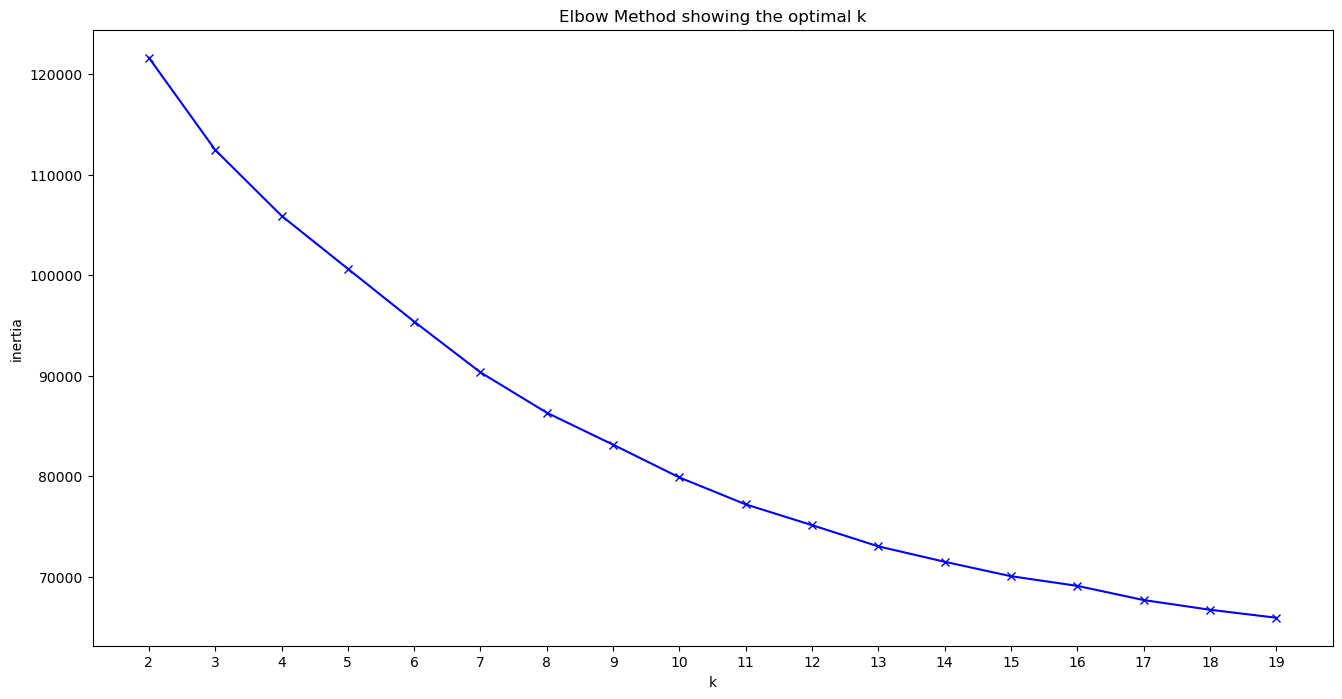

In [37]:
#Elbow graph of inertia
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_stan)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

C:\Users\Abel_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abel_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abel_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abel_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Text(0.5, 1.0, 'Silhouette score showing the optimal k')

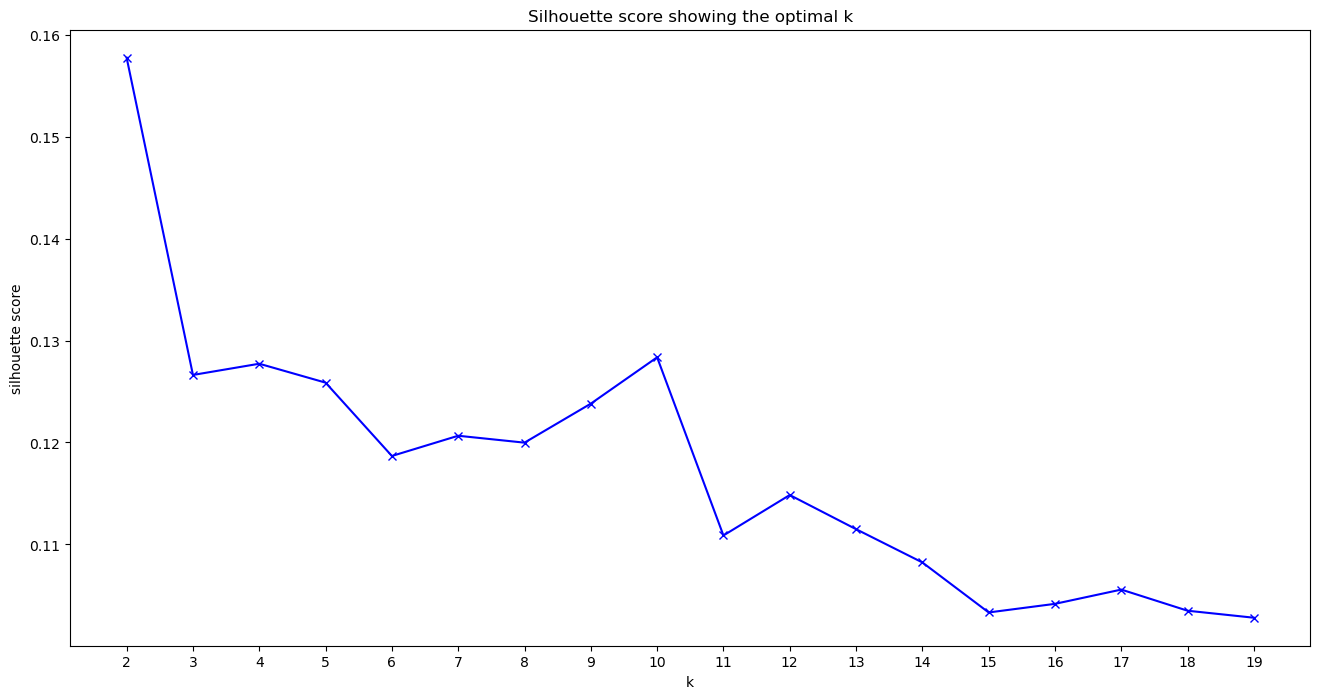

In [38]:
#silhouette score

K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_stan)
    silhouette.append(silhouette_score(X_stan, kmeans.predict(X_stan)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette score showing the optimal k')

Clustering the songs

In [39]:
kmeans = KMeans(n_clusters=11).fit(X_stan) #despite not having a clear elbow I went for 11 clusters as it seemed a reasonable amount for the the number of available songs

C:\Users\Abel_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [40]:
kmeans.inertia_

77212.43018303

In [41]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_stan)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0      135
1     1093
2      790
3      401
4      889
5     1823
6     1529
7      482
8     1504
9      738
10    1591
Name: count, dtype: int64

In [42]:
features['cluster'] = clusters

In [43]:
features #with the cluster column at the end

,song,artist,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,cluster
0,Junk - Remastered 2011,Paul McCartney,2EnRJ8kjTFpEZZWwbTNKZM,0.712,0.0862,9.0,-17.696,1.0,0.0325,0.814000,...,0.315,90.666,audio_features,2EnRJ8kjTFpEZZWwbTNKZM,spotify:track:2EnRJ8kjTFpEZZWwbTNKZM,https://api.spotify.com/v1/tracks/2EnRJ8kjTFpE...,https://api.spotify.com/v1/audio-analysis/2EnR...,115293.0,3.0,4
1,Ordinary Pain,Stevie Wonder,4vdIA5CJLRcL6qaUY2BUCd,0.653,0.6050,10.0,-10.326,0.0,0.0499,0.068100,...,0.578,97.764,audio_features,4vdIA5CJLRcL6qaUY2BUCd,spotify:track:4vdIA5CJLRcL6qaUY2BUCd,https://api.spotify.com/v1/tracks/4vdIA5CJLRcL...,https://api.spotify.com/v1/audio-analysis/4vdI...,383160.0,4.0,10
2,I'm The Slime,Frank Zappa,6PjgiuQUxxlAtoKGh6ofzC,0.388,0.6980,6.0,-12.709,0.0,0.0739,0.002280,...,0.833,173.004,audio_features,6PjgiuQUxxlAtoKGh6ofzC,spotify:track:6PjgiuQUxxlAtoKGh6ofzC,https://api.spotify.com/v1/tracks/6PjgiuQUxxlA...,https://api.spotify.com/v1/audio-analysis/6Pjg...,214520.0,4.0,9
3,I'm The Slime,The Mothers,6PjgiuQUxxlAtoKGh6ofzC,0.388,0.6980,6.0,-12.709,0.0,0.0739,0.002280,...,0.833,173.004,audio_features,6PjgiuQUxxlAtoKGh6ofzC,spotify:track:6PjgiuQUxxlAtoKGh6ofzC,https://api.spotify.com/v1/tracks/6PjgiuQUxxlA...,https://api.spotify.com/v1/audio-analysis/6Pjg...,214520.0,4.0,9
4,"It's Alright, Ma (I'm Only Bleeding)",Bob Dylan,5Oer8yskMaCGXwGSfM7xr9,0.681,0.2570,4.0,-15.348,1.0,0.0695,0.597000,...,0.566,115.867,audio_features,5Oer8yskMaCGXwGSfM7xr9,spotify:track:5Oer8yskMaCGXwGSfM7xr9,https://api.spotify.com/v1/tracks/5Oer8yskMaCG...,https://api.spotify.com/v1/audio-analysis/5Oer...,449093.0,4.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,Rock and Roll Night Club,Mac DeMarco,757WjJ59u2NZloiDZIMBvz,0.321,0.7140,7.0,-6.634,0.0,0.0617,0.164000,...,0.611,115.524,audio_features,757WjJ59u2NZloiDZIMBvz,spotify:track:757WjJ59u2NZloiDZIMBvz,https://api.spotify.com/v1/tracks/757WjJ59u2NZ...,https://api.spotify.com/v1/audio-analysis/757W...,190091.0,4.0,10
10971,Moving Like Mike,Mac DeMarco,3gsk38xacWgtwr0yJz7aHp,0.460,0.7770,3.0,-6.273,0.0,0.1020,0.302000,...,0.888,161.725,audio_features,3gsk38xacWgtwr0yJz7aHp,spotify:track:3gsk38xacWgtwr0yJz7aHp,https://api.spotify.com/v1/tracks/3gsk38xacWgt...,https://api.spotify.com/v1/audio-analysis/3gsk...,177551.0,5.0,10
10972,Serve The Servants - 2023 Remaster,Nirvana,4PvgxcCZxATeWt4vAZOISo,0.441,0.9390,10.0,-7.579,1.0,0.0406,0.000011,...,0.571,119.907,audio_features,4PvgxcCZxATeWt4vAZOISo,spotify:track:4PvgxcCZxATeWt4vAZOISo,https://api.spotify.com/v1/tracks/4PvgxcCZxATe...,https://api.spotify.com/v1/audio-analysis/4Pvg...,215116.0,4.0,1
10973,Scentless Apprentice - 2023 Remaster,Nirvana,2nBW0vuSbiSGRpTm4SMc3Y,0.295,0.8560,1.0,-7.321,1.0,0.0519,0.000002,...,0.547,169.592,audio_features,2nBW0vuSbiSGRpTm4SMc3Y,spotify:track:2nBW0vuSbiSGRpTm4SMc3Y,https://api.spotify.com/v1/tracks/2nBW0vuSbiSG...,https://api.spotify.com/v1/audio-analysis/2nBW...,227584.0,4.0,1


### 4. Music Recommendation System

In [44]:
# Combining the two top 100 charts with the hot songs information
combined_df = pd.concat([top100, billboard100], ignore_index=True)

# Saving the combined dataset to a CSV file
combined_df.to_csv('combined_df.csv', index=False)

In [45]:
# Create a lowercase version of the song titles to improve matching
combined_df['song_lower'] = combined_df['Song'].str.lower()


##### Run this cell to input your favorite song! ↓

In [46]:
# Get user input for a song
song = input("Enter the title of your favorite song: ").lower()

Enter the title of your favorite song: we will rock you


###### Run this cell to know if your song is hot or to get a spotify recommendation! ↓

In [47]:
# Checking if the song is in the top songs list
if combined_df['song_lower'].str.contains(song).any():
    # Recommend a random song from the top songs list
    random_song = combined_df.sample()
    print(f"Yay, hot song! Here is another one for you: \n\n{random_song.iloc[0]['Song']} - {random_song.iloc[0]['Artist']}")
else:
    result = sp.search(q=song, limit=1)  # Search for the song on Spotify
    if result['tracks']['items']:
        # Get the audio features of the song
        new_song_features = sp.audio_features(result['tracks']['items'][0]['uri'])[0]
        if new_song_features:
            new_song_df = pd.DataFrame([new_song_features])

            # Drop irrelevant columns only if they exist in the DataFrame
            columns_to_drop = ['type', 'id', 'uri', 'track_href', 'analysis_url']
            for col in columns_to_drop:
                if col in new_song_df.columns:
                    new_song_df.drop(columns=col, inplace=True)

           #Transformer and cluster of the new song
            X_stan_new = transformer.transform(new_song_df)
            new_song_cluster = kmeans.predict(X_stan_new)[0]

            # Find songs in the same cluster
            possible_songs = features[features['cluster'] == new_song_cluster].reset_index()
            if not possible_songs.empty:
                random_recommendation = possible_songs.sample()
                print(f"You should try {random_recommendation.iloc[0]['song']} by {random_recommendation.iloc[0]['artist']}")
            else:
                print("No similar songs found in the current top list.")
        else:
            print("Sorry, we couldn't find the audio features for that song on Spotify.")
    else:
        print("Sorry, we couldn't find that song on Spotify.")

You should try Gotta Broken Heart Again by Prince


###### Check your recomendations's features Spotify ID and much more! ;)

In [53]:
result = sp.search(q=random_recommendation, limit=1)
new_song_features = sp.audio_features(result['tracks']['items'][0]['uri'])[0]
new_song_df = pd.DataFrame([new_song_features])
new_song_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.624,0.283,2,-12.687,1,0.0278,0.887,0.00461,0.0867,0.227,101.89,audio_features,6w8NOOj4f8FhF6346a7Ulx,spotify:track:6w8NOOj4f8FhF6346a7Ulx,https://api.spotify.com/v1/tracks/6w8NOOj4f8Fh...,https://api.spotify.com/v1/audio-analysis/6w8N...,283267,4
